In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from nsepy import get_history
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA

## Running Portfolio Optimization for Indian Stocks using VQE and QAOA

The idea is to select portfolios from a stock list of 25 Indian stock which maximise the return for a given risk. We will first find the expected returns and the covariance and try to find the most optimal portfolio (one which maximises the return) for different budgets. Our main inspiration is the [qiskit tutorial on portfolio optimization](https://qiskit.org/documentation/tutorials/finance/01_portfolio_optimization.html).

We are using mean-variance portfolio optimization technique.

### Mean-Variance Analysis

According to the [Investopedia](https://www.investopedia.com/terms/m/meanvariance-analysis.asp):

Mean-variance analysis is the process of weighing risk, expressed as variance, against expected return. Investors use mean-variance analysis to make decisions about which financial instruments to invest in, based on how much risk they are willing to take on in exchange for different levels of reward. Mean-variance analysis allows investors to find the biggest reward at a given level of risk.

### Loading the data for the 20 Indian stocks

In [ ]:
# 'ABB', 'ACC', 'BANKBARODA', 'CANBK', 'FORTIS', 'GILLETTE', 'HDFCBANK', 'ICICIBANK', 'BHEL', 'BIOCON','BASML', 'BBL', 'BEL', 'BEPL'

In [61]:
assets = [ 'ACE', 'ADSL', 'ALICON', 'TCS', 'BASF', 'CANBK', 'FORTIS', 'GILLETTE', 'HDFCBANK', 'ICICIBANK']

num_assets = len(assets)

print('The total number of assets {0}'.format(num_assets))

The total number of assets 10


In [62]:
stockStartDate = datetime.date(2019,8,20)
stockEndDate = datetime.date(2020,8,20)

In [63]:
df = pd.DataFrame()

for stock in assets:
    #stock = 'XNSE/' + stock
    df[stock] = get_history(symbol=stock, start=stockStartDate, end=stockEndDate)['Close']

In [64]:
df

,ACE,ADSL,ALICON,TCS,BASF,CANBK,FORTIS,GILLETTE,HDFCBANK,ICICIBANK
Date,,,,,,,,,,
2019-08-20,58.20,14.05,387.70,2186.75,1020.75,225.25,123.70,7035.10,2220.60,416.90
2019-08-21,54.40,13.45,383.05,2186.20,983.40,219.80,122.80,7064.20,2225.85,412.05
2019-08-22,50.60,13.55,361.55,2216.00,985.35,209.80,121.55,7124.30,2174.10,399.10
2019-08-23,53.05,13.90,379.30,2247.70,1024.75,216.70,121.35,7011.75,2162.70,395.40
2019-08-26,56.40,13.50,394.85,2276.30,1042.20,223.80,121.45,6982.65,2256.15,411.65
...,...,...,...,...,...,...,...,...,...,...
2020-08-14,61.55,22.95,335.25,2242.15,1283.70,101.30,135.40,5050.65,1034.45,361.40
2020-08-17,63.55,23.25,360.25,2253.40,1279.65,100.05,135.45,5074.65,1032.75,360.20
2020-08-18,65.00,23.00,351.40,2269.75,1314.20,102.05,140.75,5071.05,1056.50,369.55


### Plot of the price of the stocks

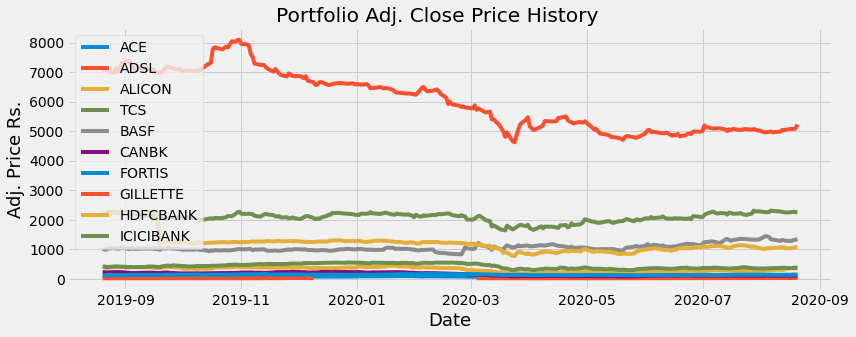

In [65]:
title = 'Portfolio Adj. Close Price History    '
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
# Loop through each stock and plot the Adj Close for each day
for c in my_stocks.columns.values:
    plt.plot( my_stocks[c],  label=c)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Adj. Price Rs.',fontsize=18)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()

### Calculate the daily percentage returns

In [66]:
#Show the daily simple returns
returns = df.pct_change()
returns

,ACE,ADSL,ALICON,TCS,BASF,CANBK,FORTIS,GILLETTE,HDFCBANK,ICICIBANK
Date,,,,,,,,,,
2019-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-21,-0.065292,-0.042705,-0.011994,-0.000252,-0.036591,-0.024195,-0.007276,0.004136,0.002364,-0.011633
2019-08-22,-0.069853,0.007435,-0.056128,0.013631,0.001983,-0.045496,-0.010179,0.008508,-0.023250,-0.031428
2019-08-23,0.048419,0.025830,0.049094,0.014305,0.039986,0.032888,-0.001645,-0.015798,-0.005244,-0.009271
2019-08-26,0.063148,-0.028777,0.040997,0.012724,0.017029,0.032764,0.000824,-0.004150,0.043210,0.041098
...,...,...,...,...,...,...,...,...,...,...
2020-08-14,0.000813,0.013245,0.097561,-0.005456,-0.008764,-0.008321,0.020731,0.004885,-0.023228,-0.018068
2020-08-17,0.032494,0.013072,0.074571,0.005018,-0.003155,-0.012340,0.000369,0.004752,-0.001643,-0.003320
2020-08-18,0.022817,-0.010753,-0.024566,0.007256,0.027000,0.019990,0.039129,-0.000709,0.022997,0.025958


### Calculate the covariance

In [67]:
cov_matrix_annual = returns.cov() * 239
cov_matrix_annual

,ACE,ADSL,ALICON,TCS,BASF,CANBK,FORTIS,GILLETTE,HDFCBANK,ICICIBANK
ACE,0.377041,0.099891,0.121422,0.055135,0.049713,0.175748,0.066118,0.045821,0.121595,0.150893
ADSL,0.099891,0.369603,0.066642,0.012799,-0.007018,0.095030,0.026302,0.034175,0.002008,0.067296
ALICON,0.121422,0.066642,0.330683,0.046972,0.037009,0.113299,0.055342,0.036490,0.084785,0.098657
TCS,0.055135,0.012799,0.046972,0.113900,0.039996,0.060253,0.038581,0.030244,0.059014,0.074650
BASF,0.049713,-0.007018,0.037009,0.039996,0.209624,0.087354,0.044636,0.018876,0.060855,0.066442
CANBK,0.175748,0.095030,0.113299,0.060253,0.087354,0.285595,0.068940,0.044347,0.151263,0.184251
FORTIS,0.066118,0.026302,0.055342,0.038581,0.044636,0.068940,0.120068,0.024269,0.047546,0.065790
GILLETTE,0.045821,0.034175,0.036490,0.030244,0.018876,0.044347,0.024269,0.051148,0.040843,0.050321
HDFCBANK,0.121595,0.002008,0.084785,0.059014,0.060855,0.151263,0.047546,0.040843,0.394215,0.171497
ICICIBANK,0.150893,0.067296,0.098657,0.074650,0.066442,0.184251,0.065790,0.050321,0.171497,0.261654


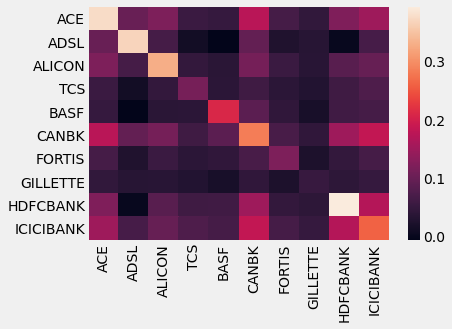

In [68]:
import seaborn as sns
sns.heatmap(cov_matrix_annual, 
        xticklabels=cov_matrix_annual.columns,
        yticklabels=cov_matrix_annual.columns)

### Creating optimal the most optimal portfolios for several risk factors subject to various budgets

In [69]:
mu = returns.mean().to_numpy()
sigma = cov_matrix_annual.to_numpy()

#### At first we chose the risk factor to be quite low.

In [70]:
q = 0.01                # set risk factor
penalty = num_assets      # set parameter to scale the budget penalty term

In [82]:
def print_result(result, budget):
    selection = sample_most_likely(result.eigenstate)#returns the most probable eigenstate
    
    # calculates the value of the portfolio
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)   
    print('For budget {} Optimal: selection {}, value {:.4f}'.format(budget, selection, value))
    
    final_result = {'budget': budget, 'selection': selection, 'value': value}
    return final_result

#### We will apply VQE

In [83]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()          #classical optimizer
cobyla.set_options(maxiter=500)

res = []

for budget in range(3, 7):
    qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)  #returns the hamiltonian operator
    ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')  #develop the variational form
    vqe = VQE(qubitOp, ry, cobyla)         #apply vqe
    vqe.random_seed = seed

    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

    result = vqe.run(quantum_instance, massive=True)

    selection_vqe = print_result(result, budget)
    
    res_vqe.append(selection_vqe)

For budget 3 Optimal: selection [0. 0. 0. 0. 0. 0. 1. 1. 0. 1.], value 0.0074
For budget 4 Optimal: selection [1. 1. 1. 0. 0. 0. 0. 0. 0. 1.], value 0.0206
For budget 5 Optimal: selection [0. 1. 1. 0. 1. 0. 0. 1. 1. 0.], value 0.0193


We will apply Classical Optimization

In [76]:
for budget in range(3, 7):
    qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)
    exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
    result = exact_eigensolver.run()

    print_result(result, budget)

For budget 3 Optimal: selection [0 1 0 1 1 0 0 0 0 0], value 0.0032
For budget 4 Optimal: selection [0 1 0 1 1 0 1 0 0 0], value 0.0058
For budget 5 Optimal: selection [0 1 0 1 1 0 1 1 0 0], value 0.0096
For budget 6 Optimal: selection [0 1 1 1 1 0 1 1 0 0], value 0.0173
For budget 7 Optimal: selection [1 1 1 1 1 0 1 1 0 0], value 0.0282


### Let us compare the results

#### To Do:

* Analyze the results (Compare and plot)
* Understand and work on QAOA
* Write a blog about the results